>#### https://github.com/gwding/draw_convnet/blob/master/draw_convnet.py

## Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, VGG19, DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import numpy as np
import os
import random
import cv2
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%load_ext tensorboard

2023-11-16 18:00:09.451745: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 18:00:09.472829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 18:00:09.472856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 18:00:09.472870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 18:00:09.477166: I tensorflow/core/platform/cpu_feature_g

## Training

In [2]:
IMAGE_HEIGHT=50
IMAGE_WIDTH=50
BATCH_SIZE=32

def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'Water':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df
df = get_pathframe('merged_images/')
df.head()

def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)


def dataset_train(X,Y):
  dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=200)
  dataset_train=dataset.take(600)
  dataset_test=dataset.skip(600)
  dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
  dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
  return dataset_train, dataset_test

dataset_train, dataset_test=dataset_train(X,Y)

# def prepare_dataset(X, Y):
#     dataset = tf.data.Dataset.zip((X, Y))
#     dataset = dataset.shuffle(buffer_size=1000)
#     dataset_size = len(df)
#     train_size = int(0.6 * dataset_size)
#     val_size = int(0.2 * dataset_size)
#     test_size = dataset_size - train_size - val_size

#     train_dataset = dataset.take(train_size)
#     val_dataset = dataset.skip(train_size)
#     test_dataset = val_dataset.skip(val_size)
#     val_dataset = val_dataset.take(test_size)

#     train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
#     val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
#     test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

#     return train_dataset, val_dataset, test_dataset

# train_data, val_data, test_data = prepare_dataset(X, Y) 

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(50, 50, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


2023-11-16 18:00:11.369889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 18:00:11.391261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-16 18:00:11.391379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(32, 50, 50, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [4]:
dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(32, 50, 50, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 50, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 32)         

2023-11-16 18:01:14.554696: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fda444394e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-16 18:01:14.554713: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-16 18:01:14.557359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-16 18:01:14.608523: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 2s 30ms/step - loss: 0.5530 - accuracy: 0.8003 - val_loss: 0.1415 - val_accuracy: 0.9948
Epoch 2/200
18/18 [==============================] - 0s 25ms/step - loss: 0.0856 - accuracy: 0.9809 - val_loss: 0.0720 - val_accuracy: 0.9946
Epoch 3/200
18/18 [==============================] - 0s 26ms/step - loss: 0.0376 - accuracy: 0.9896 - val_loss: 0.0357 - val_accuracy: 0.9948
Epoch 4/200
18/18 [==============================] - 0s 27ms/step - loss: 0.0209 - accuracy: 0.9983 - val_loss: 0.0461 - val_accuracy: 0.9948
Epoch 5/200
18/18 [==============================] - 0s 25ms/step - loss: 0.0326 - accuracy: 0.9965 - val_loss: 0.0293 - val_accuracy: 0.9947
Epoch 6/200
18/18 [==============================] - 0s 26ms/step - loss: 0.0202 - accuracy: 0.9965 - val_loss: 0.0207 - val_accuracy: 0.9948
Epoch 7/200
18/18 [==============================] - 0s 27ms/step - loss: 0.0112 - accuracy: 0.9983 - val_loss: 0.0203 - val_accuracy: 0.9947
Epoch 8/200
18/18 

INFO:tensorflow:Assets written to: my_model/assets


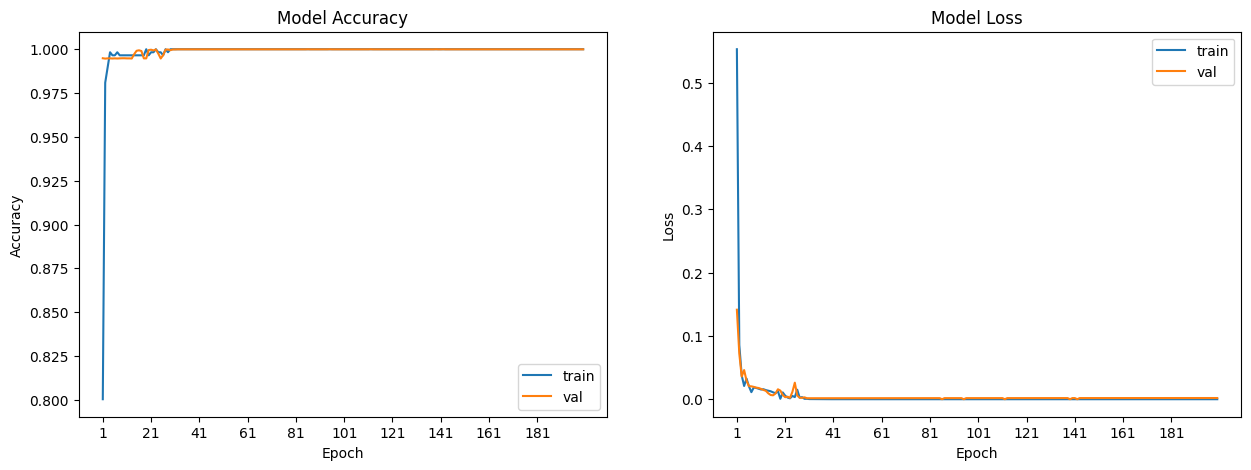

****************The model history plot of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9999
Test: accuracy = 0.999931  ;  loss = 0.001894 
455/455 [==============================] - 0s 827us/step


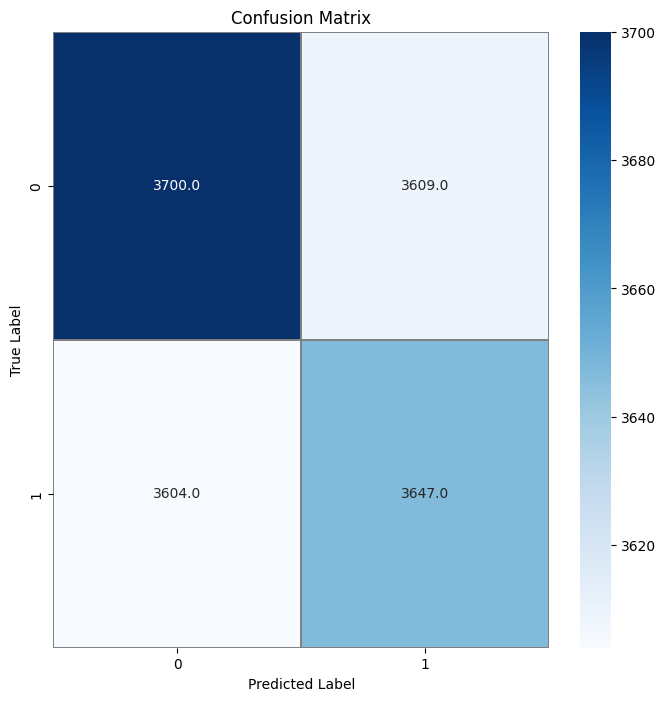

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      7309
           1       0.50      0.50      0.50      7251

    accuracy                           0.50     14560
   macro avg       0.50      0.50      0.50     14560
weighted avg       0.50      0.50      0.50     14560

****************The Accuracy of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 0s 843us/step


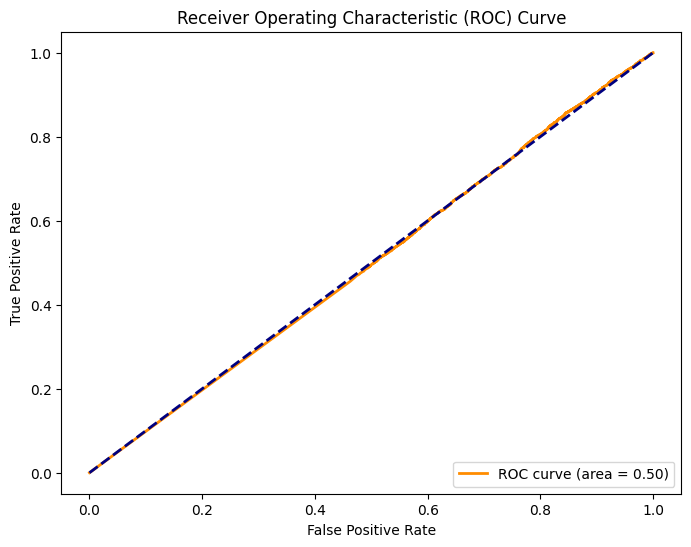

****************The Plotting AUC_ROC Curve for the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25685377 (97.98 MB)
Trainable params: 25632257 (97.78 MB

INFO:tensorflow:Assets written to: my_model/assets


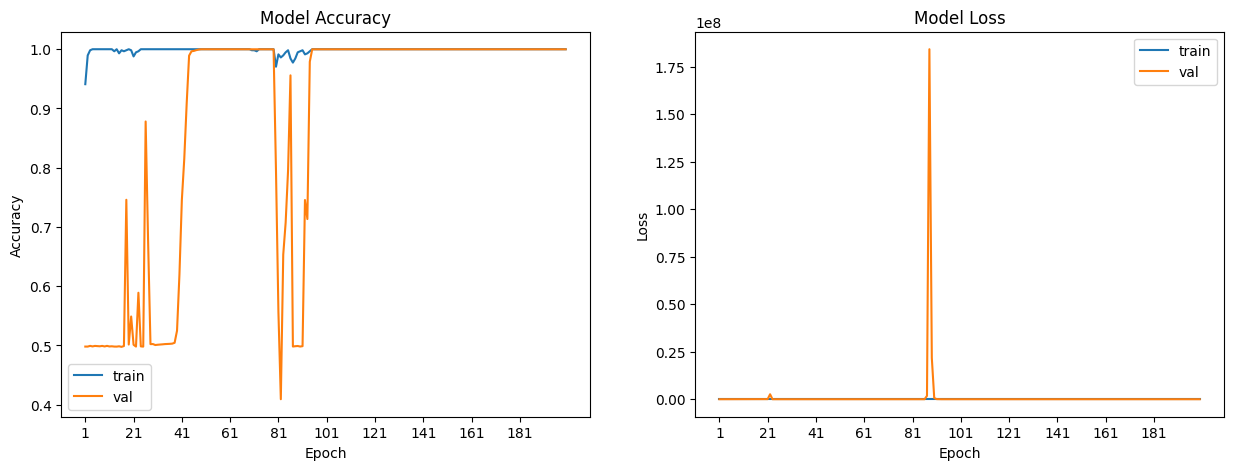

****************The model history plot of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 2s 4ms/step - loss: 0.0088 - accuracy: 0.9999
Test: accuracy = 0.999863  ;  loss = 0.008766 
455/455 [==============================] - 2s 4ms/step


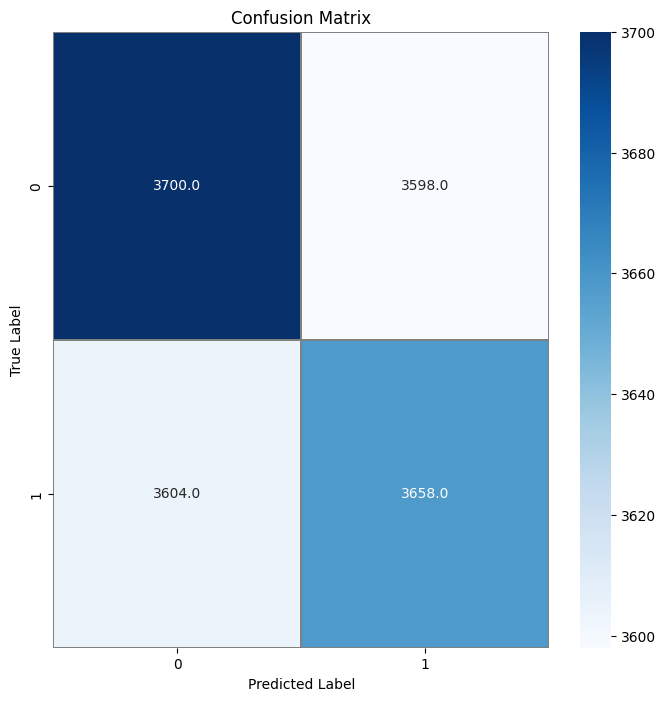

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      7298
           1       0.50      0.50      0.50      7262

    accuracy                           0.51     14560
   macro avg       0.51      0.51      0.51     14560
weighted avg       0.51      0.51      0.51     14560

****************The Accuracy of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 2s 4ms/step


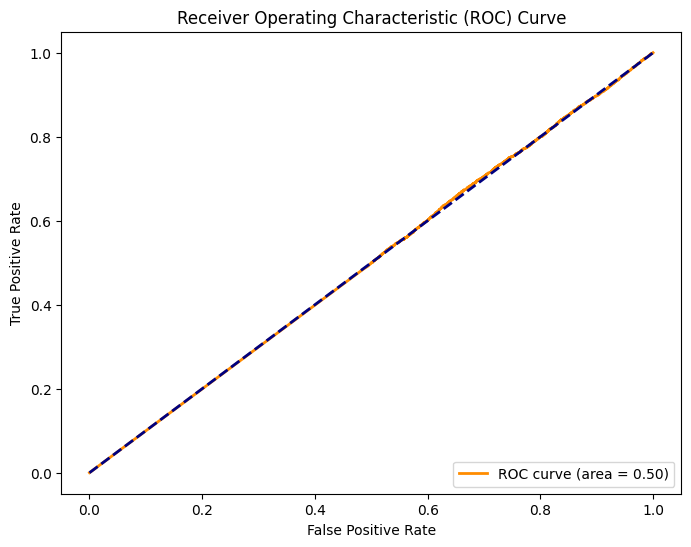

****************The Plotting AUC_ROC Curve for the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 50, 96)        7296      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 24, 24, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 256)       614656    
    

INFO:tensorflow:Assets written to: my_model/assets


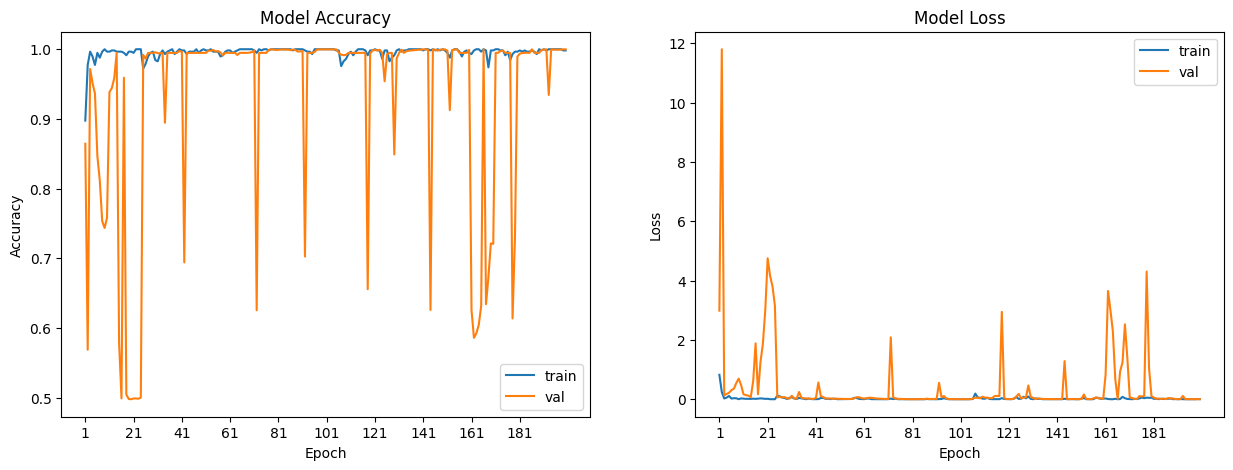

****************The model history plot of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 0.9998
Test: accuracy = 0.999794  ;  loss = 0.002525 
455/455 [==============================] - 1s 3ms/step


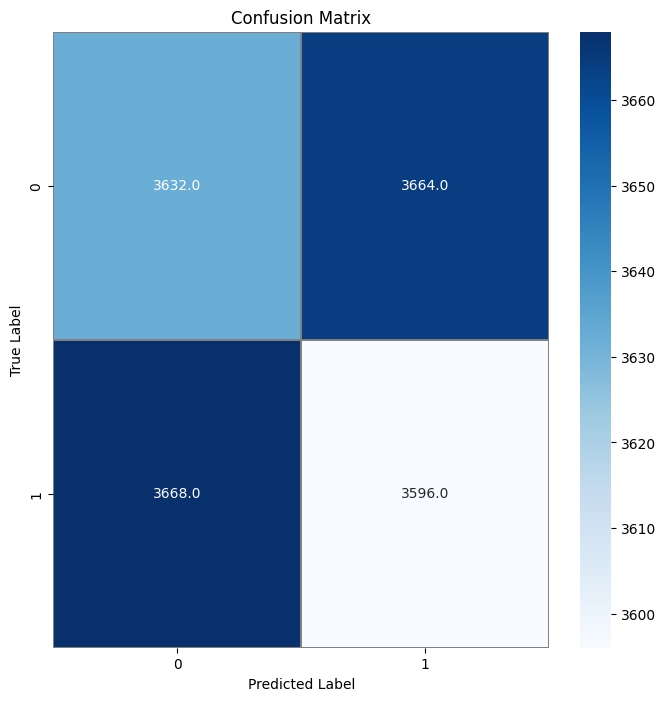

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      7296
           1       0.50      0.50      0.50      7264

    accuracy                           0.50     14560
   macro avg       0.50      0.50      0.50     14560
weighted avg       0.50      0.50      0.50     14560

****************The Accuracy of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 1s 3ms/step


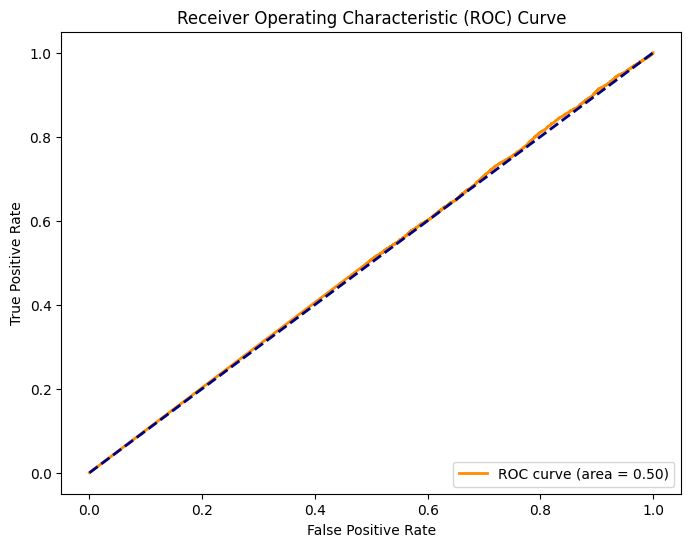

****************The Plotting AUC_ROC Curve for the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
****************VGG19 model created and saved as 'vggnet_model.png'.****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
Epoch 1/200
18/18 [==============================] - 5s 123ms/step - loss: 5.3391 - accuracy: 0.5330 - val_loss: 0.7551 - val_accuracy: 0.5012
Epoch 2/200
18/18 [==============================] - 2s 118ms/step - loss: 0.5642 - accuracy: 0.6476 - val_loss: 0.0907 - val_accuracy: 0.9927
Epoch 3/200
18/18 [==============================] - 2s 117ms/step - loss: 0.3571 - accuracy: 0.8785 - val_loss: 0.1085 - val_accuracy: 0.9948
Epoch 4/200
18/18 [==============================] - 2s 119ms/s

INFO:tensorflow:Assets written to: my_model/assets


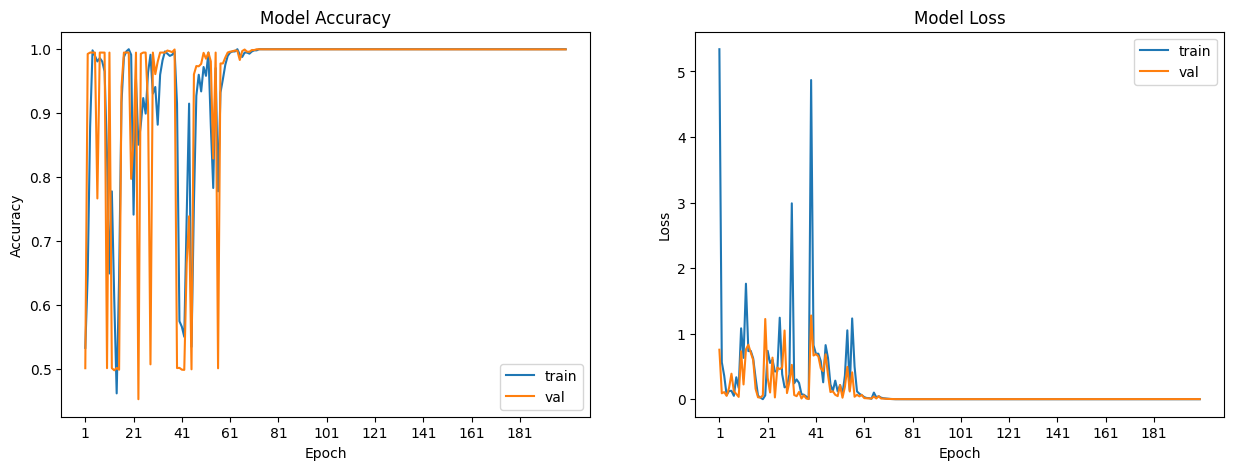

****************The model history plot of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 2s 4ms/step - loss: 0.0019 - accuracy: 0.9997
Test: accuracy = 0.999725  ;  loss = 0.001875 
455/455 [==============================] - 2s 4ms/step


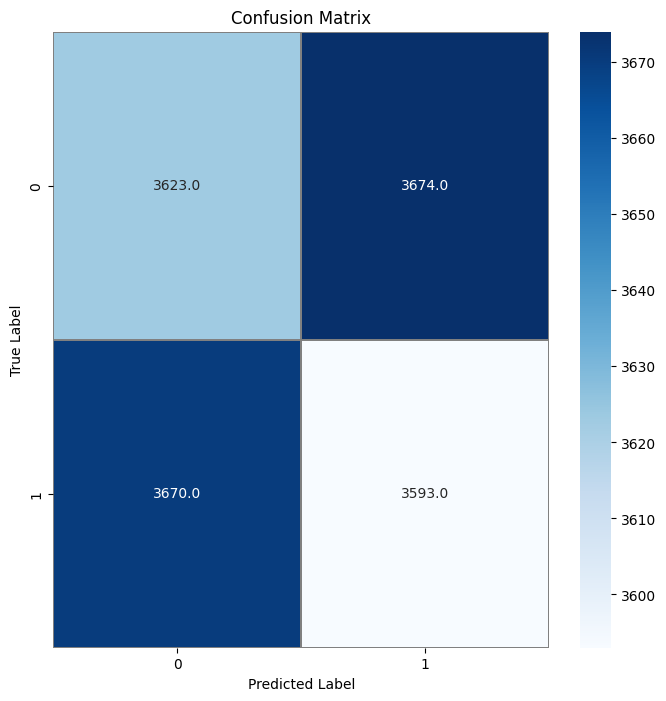

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      7297
           1       0.49      0.49      0.49      7263

    accuracy                           0.50     14560
   macro avg       0.50      0.50      0.50     14560
weighted avg       0.50      0.50      0.50     14560

****************The Accuracy of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 2s 4ms/step


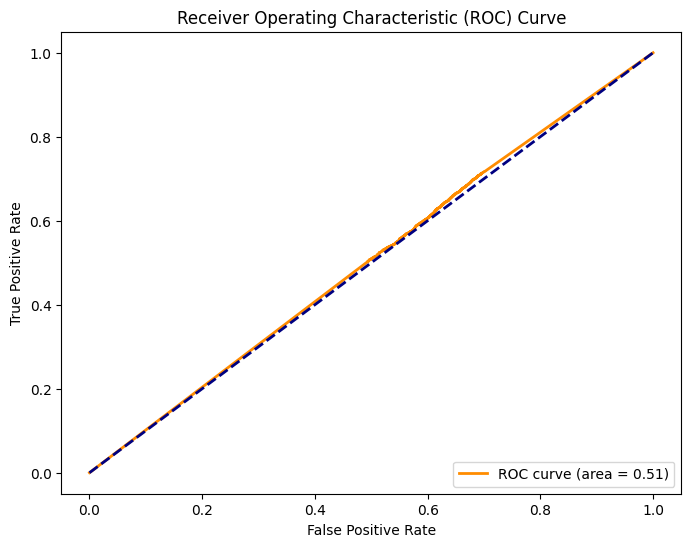

****************The Plotting AUC_ROC Curve for the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 56, 56, 3)            0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 25, 25, 

INFO:tensorflow:Assets written to: my_model/assets


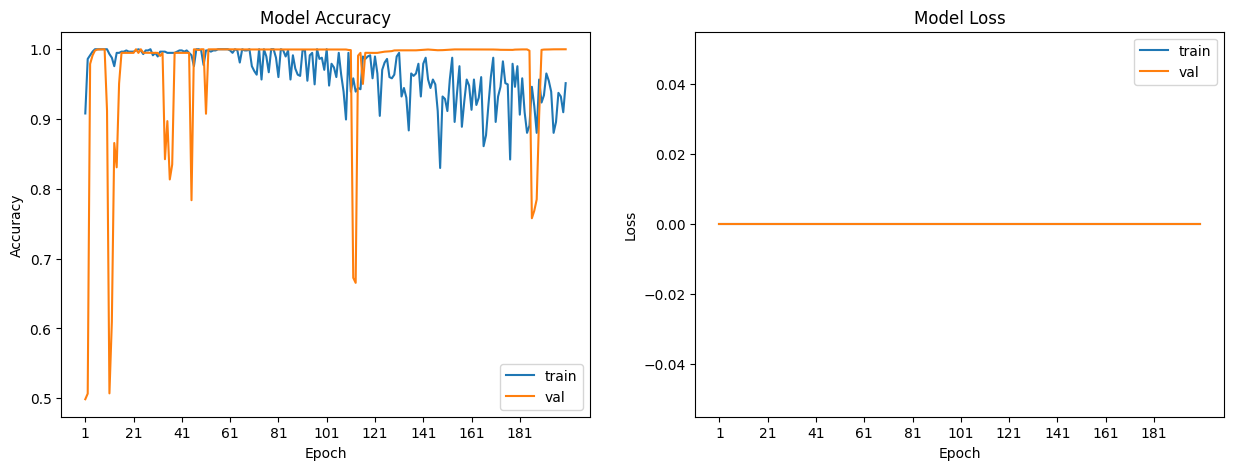

****************The model history plot of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 3s 7ms/step - loss: 0.0000e+00 - accuracy: 0.9999
Test: accuracy = 0.999931  ;  loss = 0.000000 
455/455 [==============================] - 3s 6ms/step


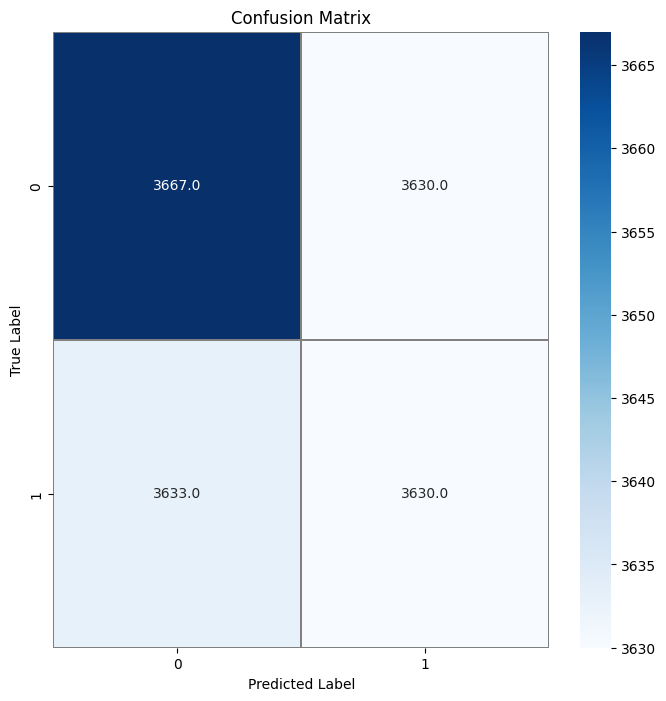

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      7297
           1       0.50      0.50      0.50      7263

    accuracy                           0.50     14560
   macro avg       0.50      0.50      0.50     14560
weighted avg       0.50      0.50      0.50     14560

****************The Accuracy of the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
455/455 [==============================] - 3s 6ms/step


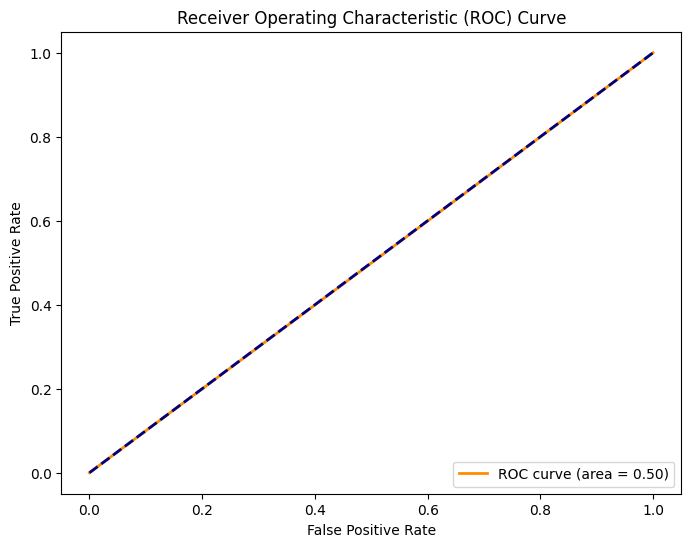

****************The Plotting AUC_ROC Curve for the model****************
Choose a neural network model:
1. CNN Model
2. ResNet Model
3. AlexNet Model
4. VGG19 Model
5. DenseNet Model
6. Model History Plot
7. Model Accuracy
8. Auc_ROC Curve
9. Exit
Exiting the program. Goodbye!


In [6]:
num_classes = 1
# IMAGE_WIDTH = 50
# IMAGE_HEIGHT = 50
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# Define a function to create the CNN model
def create_cnn_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(input_shape)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    opt=tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=opt,
                loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
                metrics=['accuracy'])
    plot_model(model, to_file='cnn_model.png', show_shapes=True)
    
    # Define log directory for TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return model

# Define a function to create the ResNet-based model
def create_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    plot_model(model, to_file='resnet_model.png',show_shapes=True)
    
    # Define log directory for TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return model

# Define a function to create the AlexNet model
def create_alexnet_model(input_shape , num_classes=1):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))# 3rd max pool layer
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(4096, activation="relu")) # 1st dense layer
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(4096, activation="relu"))# 2nd dense layer
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation="sigmoid"))# 3rd dense layer
    model.summary()
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])    
    plot_model(model, to_file='alexnet_model.png',show_shapes=True)
    
    # Define log directory for TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return model

# Define a function to create the VGG19 model
def create_vgg19_model(input_shape):
    base_model = VGG19(
        include_top=False,  # Exclude the top classification layer
        weights="imagenet",  # Use pre-trained weights from ImageNet
        input_shape=input_shape  # Input shape of your data
    )

    # Create a Sequential model and add the VGG19 base model to it
    model = Sequential()
    model.add(base_model)# Add the VGG19 base model
    model.add(Flatten()) # Add your custom classification head on top of the VGG19 base
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))  
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    
    # Define log directory for TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") 
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    plot_model(model, to_file='vgg19_model.png',show_shapes=True)
    return model

# Define a function to create the DenseNet model
def create_densenet_model(input_shape):
    model_d = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape) 
    x = model_d.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dense(512, activation='relu')(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    preds = Dense(num_classes, activation='sigmoid')(x)  # FC-layer
    model = Model(inputs=model_d.input, outputs=preds)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define log directory for TensorBoard
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return model


def plot_model_history():
    model_history = model.fit(dataset_train,epochs=200,validation_data=dataset_test)
    # Save the model
    model.save("my_model")

    acc = 'accuracy' if 'accuracy' in model_history.history else 'acc'
    val_acc = 'val_accuracy' if 'val_accuracy' in model_history.history else 'val_acc'
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(range(1, len(model_history.history[acc]) + 1, len(model_history.history[acc]) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    
    loss = 'loss' if 'loss' in model_history.history else 'mse'
    val_loss = 'val_loss' if 'val_loss' in model_history.history else 'val_mse'

    axs[1].plot(range(1, len(model_history.history[loss]) + 1), model_history.history[loss])
    axs[1].plot(range(1, len(model_history.history[val_loss]) + 1), model_history.history[val_loss])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(range(1, len(model_history.history[loss]) + 1, len(model_history.history[loss]) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def accuracy(model,dataset_test):
    # Predict the values from the validation dataset
    loss, accuracy = model.evaluate(dataset_test)
    print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))
    y_pred =  model.predict(dataset_test)
    y_p = np.where(y_pred > 0.5, 1, 0)
    test_data = dataset_test.unbatch()
    y_g = []
    for image, label in  test_data:
        y_g.append(label.numpy())

    confusion_mtx = confusion_matrix(y_g, y_p)
    # plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= '.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    report = classification_report(y_g, y_p, target_names=['0','1'])
    print(report)


# Function to plot ROC curve and calculate AUC
def plot_roc_curve(model, dataset_test):
    # Predict the probabilities for positive class
    y_pred_prob = model.predict(dataset_test)
    
    # Extracting true labels
    y_true = np.array([label.numpy() for _, label in dataset_test.unbatch()])
    
    # Calculate False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    
    # Calculate Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    

# Display a menu for choosing the neural network model
def main_menu():
    print("Choose a neural network model:")
    print("1. CNN Model")
    print("2. ResNet Model")
    print("3. AlexNet Model")
    print("4. VGG19 Model")
    print("5. DenseNet Model")
    print("6. Model History Plot")
    print("7. Model Accuracy")
    print("8. Auc_ROC Curve")
    print("9. Exit")

# Input image shape

while True:
    main_menu()
    choice = input("Enter the number of your choice: ")

    if choice == '1':
        model = create_cnn_model(input_shape)
        model.summary()
        print("****************CNN model created and saved as 'cnn_model.png'.****************")
    elif choice == '2':
        model = create_resnet_model(input_shape)
        model.summary()
        print("****************ResNet model created and saved as 'resnet_model.png'.****************")
    elif choice == '3':
        model = create_alexnet_model(input_shape)
        model.summary()
        print("****************AlexNet model created and saved as 'alexnet_model.png'.****************")
    elif choice == '4':
        model = create_vgg19_model(input_shape)
        print("****************VGG19 model created and saved as 'vggnet_model.png'.****************")
    elif choice == '5':
        model = create_densenet_model(input_shape)
        model.summary()
        plot_model(model, to_file='densenet_model.png', show_shapes=True)
        print("****************DenseNet model created and saved as 'densenet_model.png'.****************")
    elif choice == '6':
        plot_model_history()
        print("****************The model history plot of the model****************")
    elif choice == '7':
        accuracy(model,dataset_test)
        print("****************The Accuracy of the model****************")
    elif choice == '8':
        plot_roc_curve(model, dataset_test)
        print("****************The Plotting AUC_ROC Curve for the model****************")
    elif choice == '9':
        print("Exiting the program. Goodbye!")
        break
    else:
        print("Invalid choice. Please enter a valid option (1-8).")


In [ ]:
%tensorboard --logdir logs/fit